In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm

import torch
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood
from gpytorch.utils.quadrature import GaussHermiteQuadrature1D

from pymc3.gp.util import plot_gp_dist

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
# Set seed
np.random.seed(123)

# Utility models

In [4]:
def u_pow(x, theta): return x**theta

In [5]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [6]:
def u_lin(x, theta=None): return x

# Generate choice data

In [7]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

# Inference cognitive model's parameters

In [8]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [9]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

# Discrepancy modeling

In [10]:
class DiscrepancyLikelihood:
    
    def __init__(self, p, init_order, tau, n_sample):
        
        self.p = p
        self.init_order = init_order
        self.n_x = p.size(0)
        self.n_y = int(init_order.shape[0] / 2)
        self.tau = tau
        
        self.quadrature = GaussHermiteQuadrature1D(n_sample)

    def expected_log_prob(self, observations, function_dist):
        
        def log_prob_lambda(function_samples): 
            # print(function_samples.shape)  20 x Nobs
            est_eu_sorted =  self.p * torch.sigmoid(function_samples)    
            est_eu = est_eu_sorted[:, self.init_order]

            est_diff_eu = est_eu[:, self.n_y:] - est_eu[:, :self.n_y]
            return dist.Bernoulli(logits=self.tau*est_diff_eu).log_prob(observations)
        
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [11]:
class UMeanFunc(gpytorch.means.mean.Mean):
    
    def __init__(self, u, theta):
        super().__init__()
        self.u = u
        self.theta = theta
    
    def forward(self, x):
        return torch.logit(self.u(x.squeeze(-1), self.theta))        

In [12]:
class RatioKernel(gpytorch.kernels.ScaleKernel):
    
    def __call__(self, x1, x2=None, *args, **kwargs):
        if x2 is None:
            x2 = x1
        return  u(x1) * u(x2.T) * super().__call__(x1, x2, *args, **kwargs)

In [17]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, inducing_points, mean_function, kernel, learn_inducing_locations=False):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=learn_inducing_locations
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = mean_function
        # self.covar_module = CustomKernel(gpytorch.kernels.RBFKernel())
        # self.mean_module = gpytorch.means.ConstantMean()  
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [18]:
def run_inference(data, u_model, theta, tau, training_iter, learning_rate=0.1,
                  use_ratio=False, learn_inducing_locations=False, n_sample=20,
                  n_inducing_points=50):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    init_order = np.argsort(x_order)
    
    train_x = torch.from_numpy(x_sorted.astype(np.float32))
    train_y = torch.from_numpy(y.astype(np.float32))
    train_p = torch.from_numpy(p_sorted.astype(np.float32))

    inducing_points = torch.linspace(0, 1, n_inducing_points) 
    # torch.cat((torch.linspace(0, 0.1, 100), torch.linspace(0.15, 1, 20)))
    
    mean_function = UMeanFunc(u=u_model, theta=theta)
    
    if use_ratio:
        kernel = RatioKernel(gpytorch.kernels.RBFKernel())
    else:
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    model = GPClassificationModel(inducing_points=inducing_points,
                                  mean_function=mean_function, 
                                  kernel=kernel)
    likelihood = DiscrepancyLikelihood(p=train_p, tau=tau, init_order=init_order, n_sample=n_sample)

    # Find optimal model hyperparameters
    model.train()
    # likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the number of training datapoints
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

    iterator = tqdm(range(training_iter))
    
    losses = []

    for i in iterator:
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        iterator.set_postfix(loss=loss.item())
    
    return model, losses

# Run

In [19]:
u_model = u_pow
theta = 0.5
tau = 100
n = 1000
data = generate_data(u=u_model, n=n, tau=tau, theta=theta)
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,0
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,1
5796,0.116159,0.356232,0.732859,0.310642,1
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,0
8834,0.980679,0.073375,0.877985,0.777087,1


## Good prior

In [21]:
model, losses = run_inference(data=data, u_model=u_model, 
    theta=theta, tau=tau, 
    training_iter=500,
    learning_rate=0.1,
    learn_inducing_locations=False,
    n_inducing_points=50)

  0%|          | 0/500 [00:00<?, ?it/s]

In [22]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()

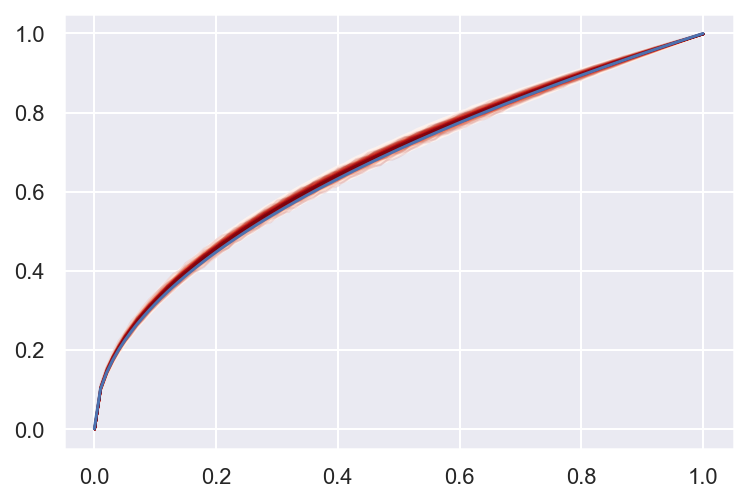

In [121]:
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_model(test_x, theta));

## Wrong prior

In [144]:
model, losses = run_inference(
    data=data, u_model=u_lin, 
    theta=theta, tau=tau, training_iter=500,
    n_sample=20,
    learning_rate=0.01,
    learn_inducing_locations=True,
    n_inducing_points=100)

  0%|          | 0/500 [00:00<?, ?it/s]

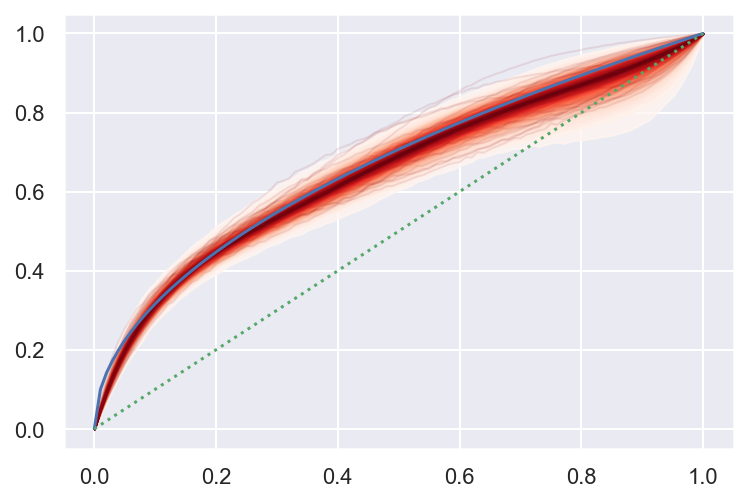

In [145]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_model(test_x, theta))
ax.plot(test_x, u_lin(test_x, None), ls=':', color='C2')

## Change inference parameters

In [23]:
model, losses = run_inference(
    data=data, u_model=u_lin, 
    theta=theta, tau=tau, n_samples=1, training_iter=200,
    learning_rate=0.04,
    jitter=1e-07,
    learn_inducing_locations=False,
    n_inducing_points=100)

  0%|          | 0/200 [00:00<?, ?it/s]

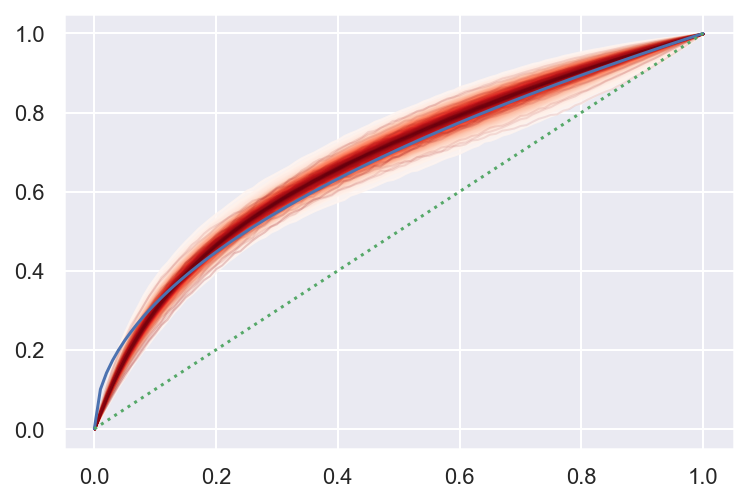

In [24]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_model(test_x, theta))
ax.plot(test_x, u_lin(test_x, None), ls=':', color='C2')

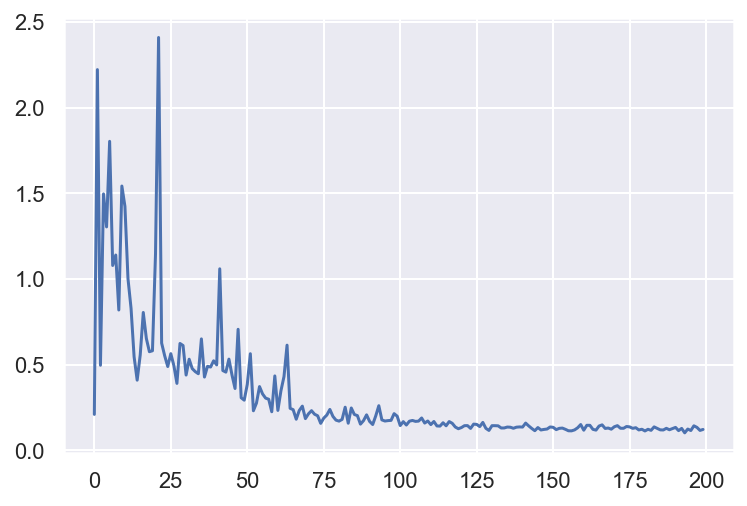

In [96]:
plt.plot(losses)